In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lightkurve import search_targetpixelfile
from lightkurve import KeplerTargetPixelFile

from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.psf import BasicPSFPhotometry

from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table

from photutilspsf.photutilspsf import wrapper_supplement_olivares_with_gaia_coordinates_on_tpf


In [2]:
from copy import deepcopy
import pickle

In [37]:
def define_photometry(sigma_psf=0.5, group_psf=1.5, fitshape=(11,11), psf_model=None):
    daogroup = DAOGroup(group_psf *
                        sigma_psf * 
                        gaussian_sigma_to_fwhm)

    bkg = MMMBackground()
    fitter = LevMarLSQFitter()
    if psf_model is None:
        psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

    psf_model.x_0.fixed = True
    psf_model.y_0.fixed = True
    
    return BasicPSFPhotometry(group_maker=daogroup,
                              bkg_estimator=bkg,
                              psf_model=psf_model,
                              fitter=LevMarLSQFitter(),
                              fitshape=fitshape,
                              aperture_radius=5)

def get_members_photometry_table(photometry, memberspath, TPF, index):
    image = TPF.flux[index,:,:]
    rselect = wrapper_supplement_olivares_with_gaia_coordinates_on_tpf(TPF,
                                                                       memberspath)
    pos = Table(names=['x_0', 'y_0'], data=[rselect['xcentroid'],
                                            rselect['ycentroid']])
    result_table =  photometry(image=image, init_guesses=pos)
    del image
    return result_table
    
def get_members_photometry_residual_image(photometry):
    return photometry.get_residual_image()

In [18]:
#200062524 -- 200062583
EPIC = 200062560
C = 7
index = 256
memberspath = 'data/olivares_members_r147.fit'

TPF = search_targetpixelfile(EPIC).download()

In [43]:
psf_model = pickle.load(open( "data/epsf29.p", "rb" ))

In [45]:
photometry = define_photometry(sigma_psf=.5, group_psf=1.5, psf_model=psf_model)

result_tab = get_members_photometry_table(photometry, memberspath, TPF,index)

residual_image = get_members_photometry_residual_image(photometry)

Query finished.


/home/ekaterina/Documents/Science/Flares_in_Clusters_II/psf_photometry/photutilspsf/photutilspsf.py:14: TableReplaceWarning: converted column 'priam_flags' from integer to float
  others = get_gaia_astrometry(center, radius)
/home/ekaterina/Documents/Science/Flares_in_Clusters_II/psf_photometry/photutilspsf/photutilspsf.py:14: TableReplaceWarning: converted column 'flame_flags' from integer to float
  others = get_gaia_astrometry(center, radius)


(0, 49)

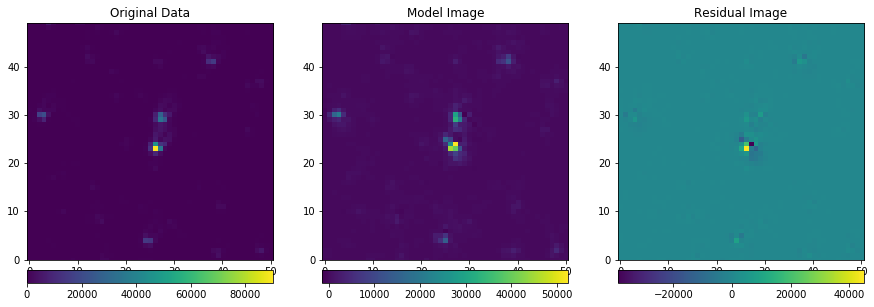

In [46]:
image = TPF.flux[index,:,:]

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1,)

plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',)
plt.ylim(0,49)
plt.title('Original Data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,3, 2)
#plt.scatter(result_tab['x_fit'],result_tab['y_fit'],c='r', marker='x')
plt.imshow(image-residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.ylim(0,49)
plt.title('Model Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,3, 3)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.ylim(0,49)


In [32]:
df = result_tab.to_pandas()
df.columns.values

array(['x_0', 'y_0', 'flux_0', 'id', 'group_id', 'x_fit', 'flux_fit',
       'y_fit', 'flux_unc'], dtype=object)

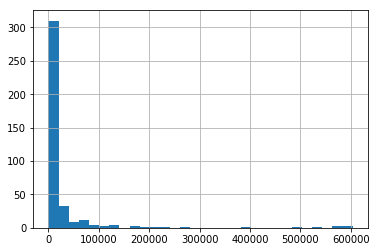

In [12]:
df.flux_0.hist(bins=30)